In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
base_dir="/content/drive/MyDrive/tea sickness dataset/"
!ls"/content/drive/MyDrive/tea sickness dataset/"

/bin/bash: ls/content/drive/MyDrive/tea sickness dataset/: No such file or directory


In [ ]:
#Menentukan direktori
dataset_dir=os.path.join(base_dir,"bahan/")

In [ ]:
#Menentukan direktori isi bahan
algal_leaf_dir=os.path.join(dataset_dir,"algal leaf/")
Anthracnose_dir=os.path.join(dataset_dir,"Anthracnose/")
bird_eye_spot_dir=os.path.join(dataset_dir,"bird eye spot/")
brown_blight_dir=os.path.join(dataset_dir,"brown blight/")
gray_light_dir=os.path.join(dataset_dir,"gray light/")
healthy_dir=os.path.join(dataset_dir,"healthy/")
red_leaf_spot_dir=os.path.join(dataset_dir,"red leaf spot/")
white_spot_dir=os.path.join(dataset_dir,"white spot/")

print("Jumlah algal leaf:", len(os.listdir(algal_leaf_dir)))
print("Jumlah Anthracnose:" , len(os.listdir(Anthracnose_dir)))
print("Jumlah bird eye spot:" , len(os.listdir(bird_eye_spot_dir)))
print("Jumlah brown blight:" , len(os.listdir(brown_blight_dir)))
print("Jumlah gray light:" , len(os.listdir(gray_light_dir)))
print("Jumlah healthy:" , len(os.listdir(healthy_dir)))
print("Jumlah red leaf spot:" , len(os.listdir(red_leaf_spot_dir)))
print("Jumlah white spot:" , len(os.listdir(white_spot_dir)))

Jumlah algal leaf: 113
Jumlah Anthracnose: 100
Jumlah bird eye spot: 100
Jumlah brown blight: 113
Jumlah gray light: 98
Jumlah healthy: 74
Jumlah red leaf spot: 143
Jumlah white spot: 142


In [ ]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.1

In [ ]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 883 files belonging to 8 classes.
Using 795 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 883 files belonging to 8 classes.
Using 88 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


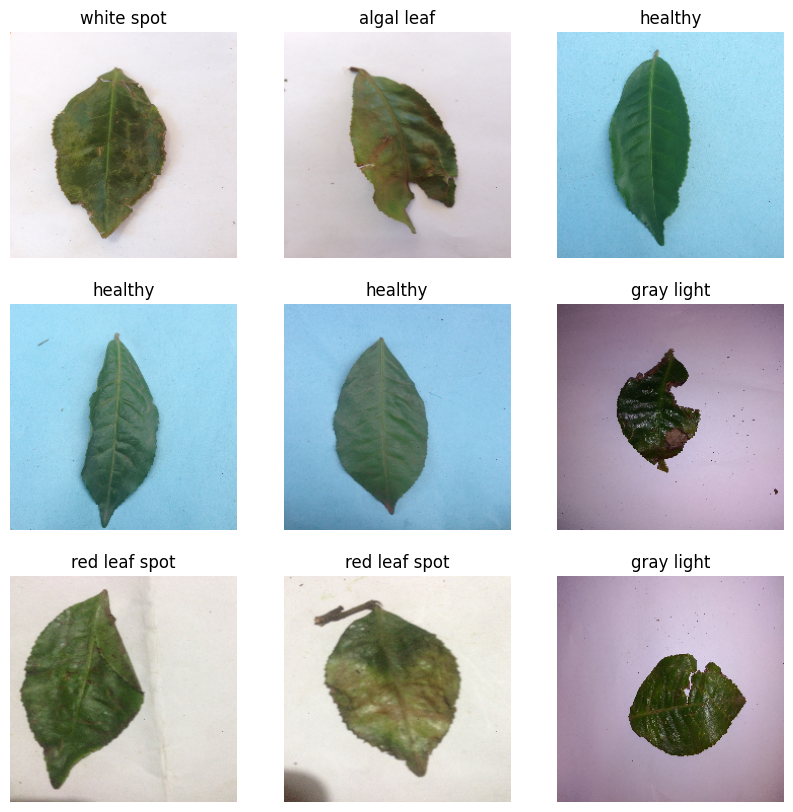

In [ ]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data Preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build Model

In [ ]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [ ]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=350,
    verbose=1
)
epochs=350

Epoch 1/350
7/7 [==============================] - 119s 13s/step - loss: 2.5876 - accuracy: 0.1283 - val_loss: 5.4701 - val_accuracy: 0.0909
Epoch 2/350
7/7 [==============================] - 44s 6s/step - loss: 2.5276 - accuracy: 0.1572 - val_loss: 4.9423 - val_accuracy: 0.0909
Epoch 3/350
7/7 [==============================] - 43s 6s/step - loss: 2.5082 - accuracy: 0.1396 - val_loss: 4.2012 - val_accuracy: 0.0909
Epoch 4/350
7/7 [==============================] - 46s 7s/step - loss: 2.4245 - accuracy: 0.1836 - val_loss: 3.2852 - val_accuracy: 0.0909
Epoch 5/350
7/7 [==============================] - 44s 6s/step - loss: 2.3928 - accuracy: 0.1635 - val_loss: 2.7409 - val_accuracy: 0.1023
Epoch 6/350
7/7 [==============================] - 44s 6s/step - loss: 2.3407 - accuracy: 0.1862 - val_loss: 2.4029 - val_accuracy: 0.0909
Epoch 7/350
7/7 [==============================] - 47s 8s/step - loss: 2.3501 - accuracy: 0.1950 - val_loss: 2.1216 - val_accuracy: 0.1250
Epoch 8/350
7/7 [========

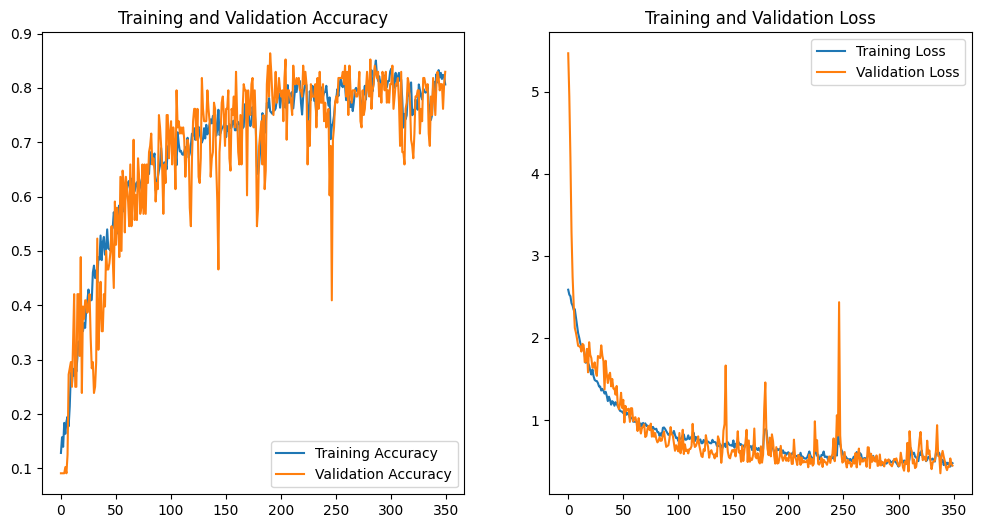

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluasi Model

Predictions:
 [7 3 5 1 3 2 4 2 5 0 4 5 6 3 5 4 7 6 0 6 7 5 2 3 5 6 4 2 3 3 7 1 3 5 7 4 3
 4 6 1 7 5 6 5 4 1 1 1 3 3 3 7 7 1 2 5 4 4 6 1 7 1 2 1 2 3 1 1 5 2 3 3 0 0
 7 2 7 6 1 2 7 3 1 4 4 4 3 7]
Labels:
 [3 3 5 1 3 2 4 2 5 0 4 5 6 7 5 0 7 6 2 6 1 5 0 3 5 6 4 2 3 3 7 1 3 5 7 2 3
 4 6 1 7 5 6 5 4 1 1 1 3 3 3 7 7 1 2 5 0 0 6 3 7 1 0 1 2 3 1 1 5 2 7 3 0 0
 7 0 7 6 1 2 7 3 7 0 4 4 3 7]

              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.86      0.92      0.89        13
           2       0.70      0.78      0.74         9
           3       0.88      0.88      0.88        16
           4       0.58      1.00      0.74         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         8
           7       0.85      0.79      0.81        14

    accuracy                           0.83        88
   macro avg       0.83      0.83      0.81        88
weighted avg       0

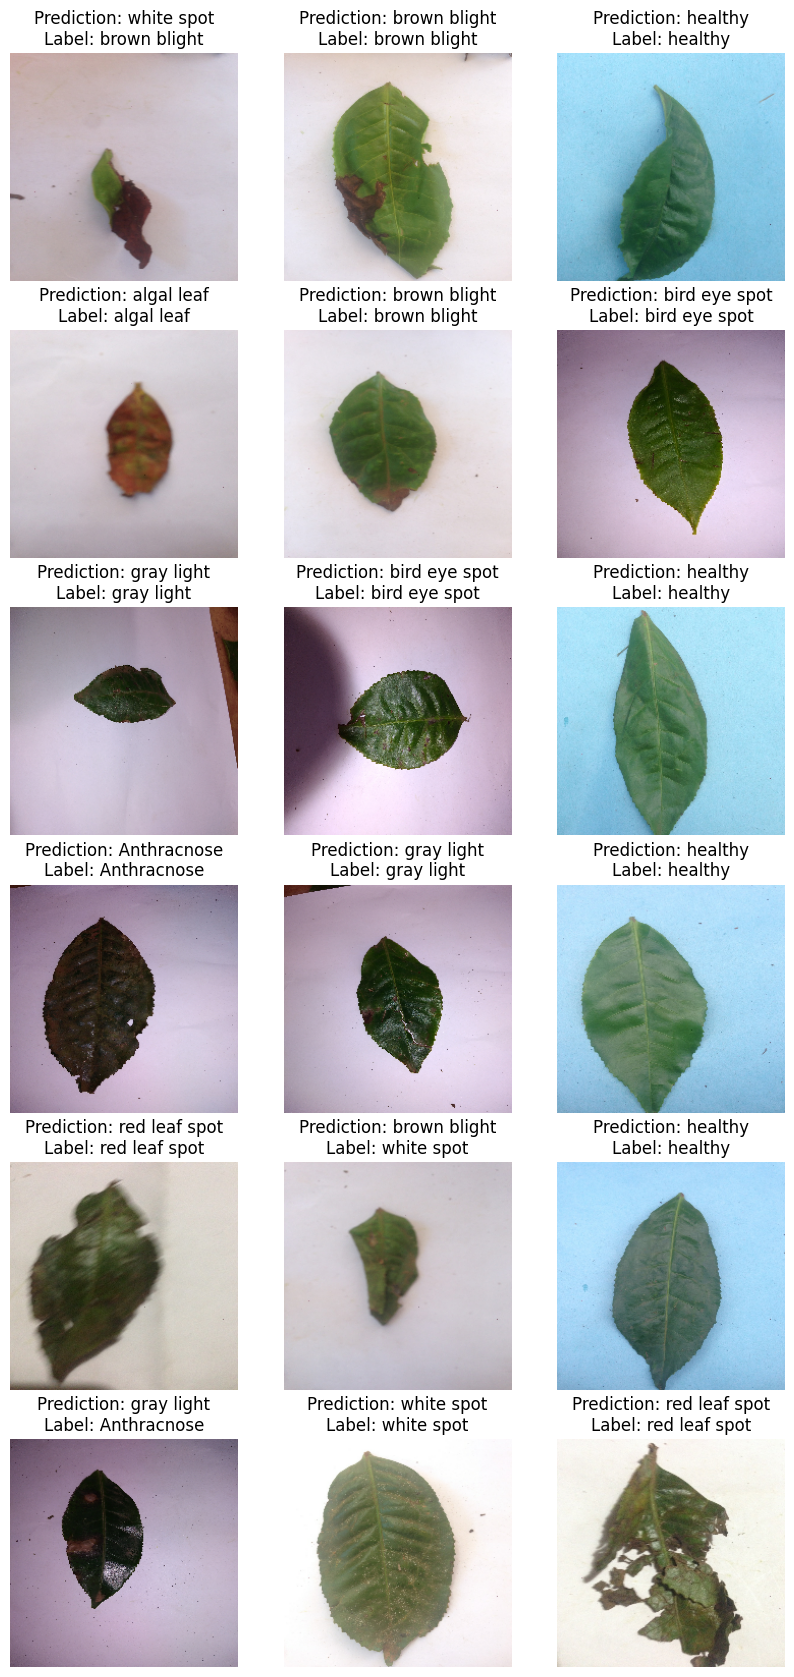

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
345,0.459757,0.827673,0.434746,0.806818
346,0.475809,0.816352,0.428301,0.806818
347,0.431744,0.823899,0.530843,0.761364
348,0.459904,0.821384,0.462160,0.806818
349,0.473367,0.806289,0.442971,0.829545


In [ ]:
latih_dir=os.path.join(base_dir,"train/")

Saving UNADJUSTEDNONRAW_thumb_7d.jpg to UNADJUSTEDNONRAW_thumb_7d.jpg
4/4 [==============================] - 2s 377ms/step
This image belongs to class: healthy


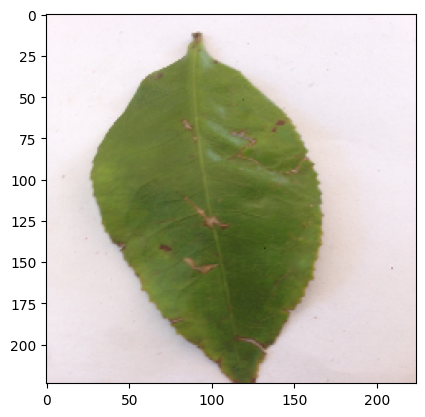

In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from tensorflow.python.ops.numpy_ops import np_config
uploaded=files.upload()

for fn in uploaded.keys():

  #Predicting image
  path=fn
  img=tf.keras.utils.load_img(path,target_size=(224,224))
  imgplot=plt.imshow(img)
  predictions = model.predict(images)
  predicted_class_index = np.argmax(predictions[0])
  class_list = os.listdir(latih_dir)
  predicted_class = class_list[predicted_class_index]
  print("This image belongs to class:", predicted_class)
